# Single Cell Optimisation Tutorial

____________


Authors of this script:

Elisabetta Iavarone @ Blue Brain Project

Werner Van Geit @ Blue Brain Project

___
### Overview:

* In this exercise we will use the **Blue Brain Python Optimisation Library** [BluePyOpt](https://github.com/BlueBrain/BluePyOpt) to create a model template for the [NEURON simulator](https://www.neuron.yale.edu/neuron/) and to constrain the model parameters.


We first import some useful Python modules.

In [4]:
%load_ext autoreload
%autoreload

import numpy
import json
import IPython, os
from json2html import *

import matplotlib.pyplot as plt
%matplotlib notebook
plt.rcParams['figure.figsize'] = 10, 10

import collections

import efel
import neurom
import neurom.viewer

import bluepyopt as bpopt
import bluepyopt.ephys as ephys

import pprint
pp = pprint.PrettyPrinter(indent=2)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Electrophysiology data
In this section we will use the **electrophysiological data** we have seen in the eFEL tutorial.

In [6]:
data_dir = "../eFEL/data/"

# Store voltage data in a dictionary step_name : [list of repetitions]
steps_v_dict = collections.OrderedDict({'LongStepNeg': [], 'ShortStepPos': [], 'LongStepPos': []})

# Store current data in a dictionary step_name : [list of repetitions]
steps_i_dict = collections.OrderedDict({'LongStepNeg': [], 'ShortStepPos': [], 'LongStepPos': []})

# Import the glob Python module to interact with the data directory
import glob

files_list = glob.glob1(data_dir, "*.dat")

for file_name in files_list:
    # Get channel and trace number from the file_name
    channel = int(file_name[:-4].split('_')[2][2:])
    tracenum = int(file_name[:-4].split('_')[-1])
    
    # Even channel numbers are voltage traces in this case
    if channel % 2 == 0:
        if "APWaveform" in file_name:
            steps_v_dict['ShortStepPos'].append(numpy.fromfile(os.path.join(data_dir,file_name)))
        if "IDRest" in file_name:
            steps_v_dict['LongStepPos'].append(numpy.fromfile(os.path.join(data_dir,file_name)))
        if "IV" in file_name:
            steps_v_dict['LongStepNeg'].append(numpy.fromfile(os.path.join(data_dir,file_name)))
            
    # Odd channel numbers are current traces in this case        
    elif channel % 2 == 1:
        if "APWaveform" in file_name:
            steps_i_dict['ShortStepPos'].append(numpy.fromfile(os.path.join(data_dir,file_name)))
        if "IDRest" in file_name:
            steps_i_dict['LongStepPos'].append(numpy.fromfile(os.path.join(data_dir,file_name)))
        if "IV" in file_name:
            steps_i_dict['LongStepNeg'].append(numpy.fromfile(os.path.join(data_dir,file_name)))

We can now plot these data.

<IPython.core.display.Javascript object>


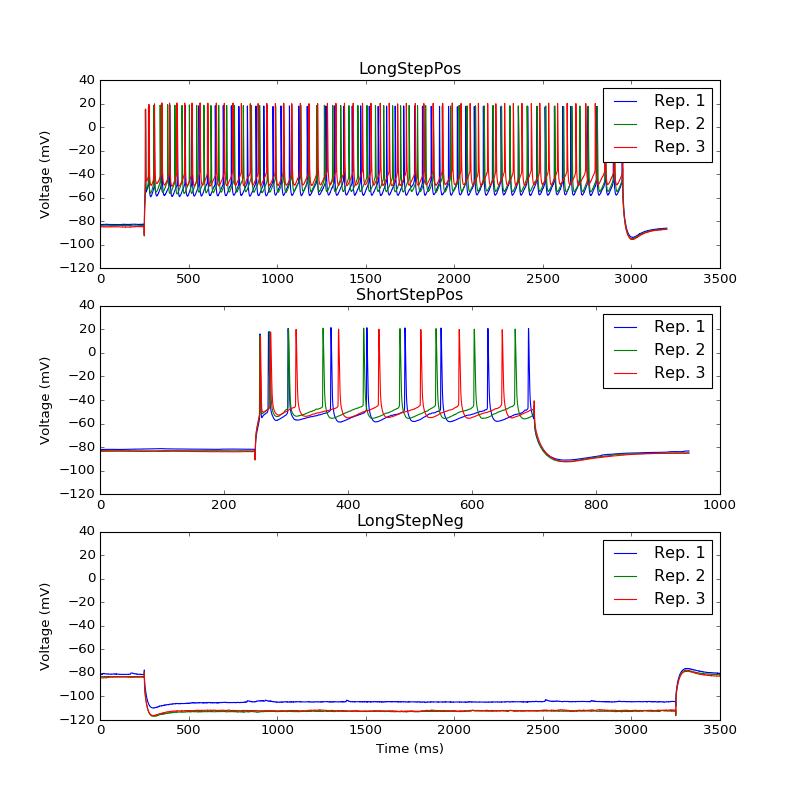

In [10]:
# Initialize a figure
fig1, axes = plt.subplots(len(steps_v_dict), sharey = True)

# Plot the voltage traces
for idx, step_name in enumerate(steps_v_dict.keys()):
    for rep, trace in enumerate(steps_v_dict[step_name]):
        data = trace.reshape(len(trace)/2,2)
        axes[idx].plot(data[:,0],data[:,1], label = 'Rep. ' + str(rep+1))
        axes[idx].set_ylabel('Voltage (mV)')
        axes[idx].legend(loc = 'best')
        axes[idx].set_title(step_name)
    axes[-1].set_xlabel('Time (ms)')

# 2. Electrophysiological features
To build a detailed neuron model, we need to quantify the electrical behavior we want to reproduce. The metrics we use are the eFeatures, that measure parameters describing for instance the shape of the action potential or the firing properties of a neuron (for examples, see [here](http://bluebrain.github.io/eFEL/eFeatures.html)).

In this particular example, we extract distinct features from the responses to the negative and positive voltage steps.
The eFeatures extracted from the data and later from the model will be used to evaluate the results of the simulations. The features values, along with the standard deviations are stored in a .json file.

In [15]:
# Extract features
import efel

# Define stimulus start and end times
steps_info = {'LongStepNeg': [250, 3250], 'ShortStepPos': [250, 700], 'LongStepPos': [250, 2950]}

# Prepare the traces for eFEL
def get_features(data):
    # All the traces converted in eFEL format
    efel_traces = {'LongStepNeg': [], 'ShortStepPos': [], 'LongStepPos': []}
    for step_name, step_traces in data.items():
        for rep in step_traces:
            data = rep.reshape(len(rep)/2,2)
            # A single eFEL trace 
            trace = {}
            trace['T'] = data[:,0]
            trace['V'] = data[:,1]
            trace['stim_start'] = [steps_info[step_name][0]]
            trace['stim_end'] = [steps_info[step_name][1]]
            trace['name'] = step_name
            
            efel_traces[step_name].append(trace)
    
    features_values = collections.defaultdict(dict)       
    
    features_values['LongStepNeg'] = efel.getMeanFeatureValues(efel_traces['LongStepNeg'], 
                                                                ['time_constant', 'voltage_deflection_begin', 
                                                                'voltage_deflection'])
    
    features_values['LongStepPos'] = efel.getMeanFeatureValues(efel_traces['LongStepPos'], 
                                                               ['mean_frequency', 'adaptation_index2', 
                                                                'ISI_CV', 'doublet_ISI'])
    
    features_values['ShortStepPos'] = efel.getMeanFeatureValues(efel_traces['ShortStepPos'], 
                                                                ['time_to_first_spike', 'AHP_depth', 
                                                                'AP_width', 'AP_height'])    
    
    mean_std_features = collections.defaultdict(lambda:collections.defaultdict(dict))
    for step_name in features_values:
        for efeature in features_values[step_name][0]:
            efeature_values = [x[efeature] for x in features_values[step_name]]
            mean_std_features[step_name][efeature] = {'mean': numpy.mean(efeature_values), 
                                                      'std': numpy.std(efeature_values)}
    
    return mean_std_features

mean_std_features = get_features(steps_v_dict)
IPython.display.HTML(json2html.convert(json=dict(mean_std_features)))

# 3. Model definition
In this section we will define the neuron model template and the parameters that we will optimize later on. 

In the following steps we will use some BluePyOpt functionalities to set-up the model template and optimize the free parameters. First of all, we use the "ephys" module to load the morphology.

In [17]:
morphology_file = 'simple.swc'
morphology = ephys.morphologies.NrnFileMorphology(morphology_file)

somatic_loc = ephys.locations.NrnSeclistLocation('somatic', seclist_name='somatic')

Now we define the parameters, some of them are "**frozen**" (i.e. they are not going to be optimised), some are "**free**" (i.e. they are going to be optimised). In a typical biophysically detailed model the free parameters are the maximal conductances of the ionic currents (Na$^+$, K$^+$ and leak in this case).

The membrane potential in the somatic location we are recording from is given:

$$C_{m}\frac{dV}{dt} = I_{l} + I_{Na} + I_{K} $$

$$C_{m}\frac{dV}{dt} = g_{l}(V-E_{l}) + \overline{g}_{Na}m^{3}h(V-E_{Na}) + \overline{g}_{K}n^{4}(V-E_{K}) $$

Where ${g}_{l}$, **${g}_{Na}$** and **${g}_{k }$** are the maximal conductances.

The frozen parameters are **$celsius$** (i.e. the simulation temperature) and **$v_{init}$** (i.e. the initial value of the membrane potential).

In [41]:
hh_mech = ephys.mechanisms.NrnMODMechanism(                                         
        name='hh',                                                                  
        suffix='hh',                                                                
        locations=[somatic_loc])

# Leak conductance (Passive membrane resistance)
gl_param = ephys.parameters.NrnSectionParameter(                                    
        name='gl_hh',                                                           
        param_name='gl_hh',                                                     
        locations=[somatic_loc],                                                    
        bounds=[0, 1],
        frozen=False)  

# Na conductance
gnabar_param = ephys.parameters.NrnSectionParameter(                                    
        name='gnabar_hh',                                                           
        param_name='gnabar_hh',                                                     
        locations=[somatic_loc],                                                    
        #bounds=[0, 1],
        value=0.0001,
        frozen=True)

# K conductance
gkbar_param = ephys.parameters.NrnSectionParameter(                              
        name='gkbar_hh',                                                         
        param_name='gkbar_hh',                                                   
        value=0.0003,
        #bounds=[0, 1],
        locations=[somatic_loc],                                                 
        frozen=True) 
# Reversal potential of leak conductance
el_param = ephys.parameters.NrnSectionParameter(                                    
        name='el_hh',                                                           
        param_name='el_hh',                                                     
        locations=[somatic_loc],                                                    
        value=-81,
        frozen=True)
# Capacitance
cm_param = ephys.parameters.NrnSectionParameter(                                 
        name='cm',                                                               
        param_name='cm',                                                         
        value=2.0,                                                               
        locations=[somatic_loc],                                                 
        frozen=True) 
# Temperature (celsius)
celsius_param = ephys.parameters.NrnGlobalParameter(                                 
        name='celsius',                                                               
        param_name='celsius',                                                         
        value=34.0,                                                                 
        frozen=True)
# Voltage at time 0
vinit_param = ephys.parameters.NrnGlobalParameter(                                 
        name='v_init',                                                               
        param_name='v_init',                                                         
        value=-81,                                                                 
        frozen=True)   

To define the cell model, we specify the morphology, ion channels and parameters

In [42]:
simple_cell = ephys.models.CellModel(                                            
        name='simple_cell',                                                      
        morph=morphology,                                                             
        mechs=[hh_mech],                                                         
        params=[cm_param, gnabar_param, gkbar_param, gl_param, el_param, celsius_param, vinit_param])   
print simple_cell

simple_cell:
  morphology:
    simple.swc
  mechanisms:
    hh: hh at ['somatic']
  params:
    cm: ['somatic'] cm = 2.0
    gnabar_hh: ['somatic'] gnabar_hh = 0.0001
    gkbar_hh: ['somatic'] gkbar_hh = 0.0003
    gl_hh: ['somatic'] gl_hh = [0, 1]
    el_hh: ['somatic'] el_hh = -81
    celsius: celsius = 34.0
    v_init: v_init = -81



We define an object that point to the location of the soma

In [43]:
soma_loc = ephys.locations.NrnSeclistCompLocation(                               
        name='soma',                                                             
        seclist_name='somatic',                                                  
        sec_index=0,                                                             
        comp_x=0.5)         

In the next step we will fit the maximal conductance of some of the ion channels in order to reproduce the eFeatures we have extracted from the data.

# 4. Setting-up a simulation
To evaluate the behavior of the model, we need to setup a simulation. We first try to fit the passive trace (negative current injection).

In [44]:
nrn = ephys.simulators.NrnSimulator()                                            

# Current amplitudes (nA) used for the different protocols, we have obtained them in the previous tutorial
IDREST = .98
IV = -0.46
APWaveform = 0.85

sweep_protocols = []                                                             
for protocol_name, amplitude in [('step1', IV)]:           
    stim = ephys.stimuli.NrnSquarePulse(                                         
                step_amplitude=amplitude,                                        
                step_delay=250,                                                  
                step_duration=3000,                                                
                location=soma_loc,                                               
                total_duration=3500)                                              
    rec = ephys.recordings.CompRecording(                                        
            name='%s.soma.v' % protocol_name,                                    
            location=soma_loc,                                                   
            variable='v')                                                        
    protocol = ephys.protocols.SweepProtocol(protocol_name, [stim], [rec])       
    sweep_protocols.append(protocol)                                             
twostep_protocol = ephys.protocols.SequenceProtocol('twostep', protocols=sweep_protocols)

default_params = {'gl_hh': 5e-4}
# {'gnabar_hh': 0.1, 'gkbar_hh': 0.03}  
responses = twostep_protocol.run(cell_model=simple_cell, param_values=default_params, sim=nrn)


<IPython.core.display.Javascript object>


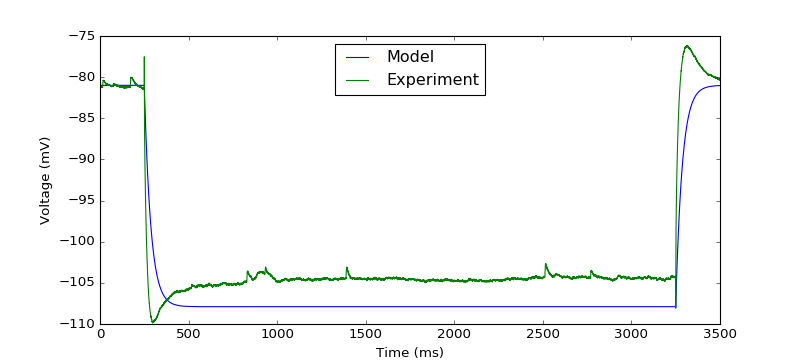

In [63]:
def plot_responses(responses):
    fig1, ax = plt.subplots(len(responses), figsize = (10,4.5))
    ax.plot(responses['step1.soma.v']['time'], responses['step1.soma.v']['voltage'], label='Model')
    data = steps_v_dict['LongStepNeg'][0].reshape(len(steps_v_dict['LongStepNeg'][0])/2,2)
    ax.plot(data[:, 0], data[:, 1], label='Experiment')
    ax.set_xlabel("Time (ms)")
    ax.set_ylabel("Voltage (mV)")
    ax.legend(loc="best")
plot_responses(responses)


The "ephys" module containes helper functionality to define the objectives function and a scoring system that will be used by the genetic algorithm.

In [46]:
efel_feature_means = {'step1': {'voltage_deflection': mean_std_features['LongStepNeg']['voltage_deflection']}}
                                                                                 
objectives = []                                                                  
                                                                                 
for protocol in sweep_protocols:                                                 
    stim_start = protocol.stimuli[0].step_delay                                  
    stim_end = stim_start + protocol.stimuli[0].step_duration                    
    for efel_feature_name, mean_std_dict in efel_feature_means[protocol.name].iteritems():
        mean = mean_std_dict['mean']
        std = mean_std_dict['std']
        feature_name = '%s.%s' % (protocol.name, efel_feature_name)              
        feature = ephys.efeatures.eFELFeature(                                   
                    feature_name,                                                
                    efel_feature_name=efel_feature_name,                         
                    recording_names={'': '%s.soma.v' % protocol.name},           
                    stim_start=stim_start,                                       
                    stim_end=stim_end,                                           
                    exp_mean=mean,                                               
                    exp_std=std)                                        
        objective = ephys.objectives.SingletonObjective(                         
            feature_name,                                                        
            feature)                                                             
        objectives.append(objective)         
        
score_calc = ephys.objectivescalculators.ObjectivesCalculator(objectives)        

cell_evaluator = ephys.evaluators.CellEvaluator(                                 
        cell_model=simple_cell,                                                  
        param_names=['gl_hh'],                                   
        fitness_protocols={twostep_protocol.name: twostep_protocol},             
        fitness_calculator=score_calc,                                           
        sim=nrn)        

print 'Score of the feature:', cell_evaluator.evaluate_with_dicts(default_params)                         


Score of the feature:
 {'step1.voltage_deflection': 9.23720372606231}


# 5. Parameters optimization 
We are now ready to run an optimisation. This procedure could require supercomputing resources and can take from some hours to days. As a proof of concept, we will run an optimization with a small population of individuals for a small number of generations.

In [53]:
optimisation = bpopt.optimisations.DEAPOptimisation(                              
        evaluator=cell_evaluator,                                                
        offspring_size = 15)    

After 14 generations, the model passive responses are fairly satisfying.

In [54]:
final_pop, hall_of_fame, logs, hist = optimisation.run(max_ngen=14)               


In [55]:
print 'Final population: ', final_pop                                            
best_ind = hall_of_fame[0]                                                       
print 'Best individual: ', best_ind                                              
print 'Fitness values: ', best_ind.fitness.values             

best_ind_dict = cell_evaluator.param_dict(best_ind)                              
print cell_evaluator.evaluate_with_dicts(best_ind_dict)                 

Final population:  [[5.4443400293903365e-05], [5.4443400293903365e-05], [5.4443400293903365e-05], [5.4443400293903365e-05], [5.4443400293903365e-05], [5.4443400293903365e-05], [5.4443400293903365e-05], [5.4443400293903365e-05], [5.4443400293903365e-05], [5.4443400293903365e-05], [5.4443400293903365e-05], [5.4443400293903365e-05], [5.4443400293903365e-05], [5.4443400293903365e-05], [5.4443400293903365e-05], [5.4443400293903365e-05], [5.4443400293903365e-05], [5.4443400293903365e-05], [5.4443400293903365e-05], [5.411841607068412e-05], [5.5810210019739876e-05], [5.6135194242959123e-05], [6.8876784218165e-05], [3.454243555054547e-05], [0.009763824559288016], [0.017647145685569222], [0.017788410213071072], [0.11228634620365194], [0.13308861358014176], [1.7502484732957667e-05]]
Best individual:  [5.4443400293903365e-05]
Fitness values:  (0.009150843289643577,)
{'step1.voltage_deflection': 0.009150843289643577}


We can also plot the evolution of the feature values from generation to generation. We can observe a progressive convergence of the model features values toward the experimental ones.

<IPython.core.display.Javascript object>


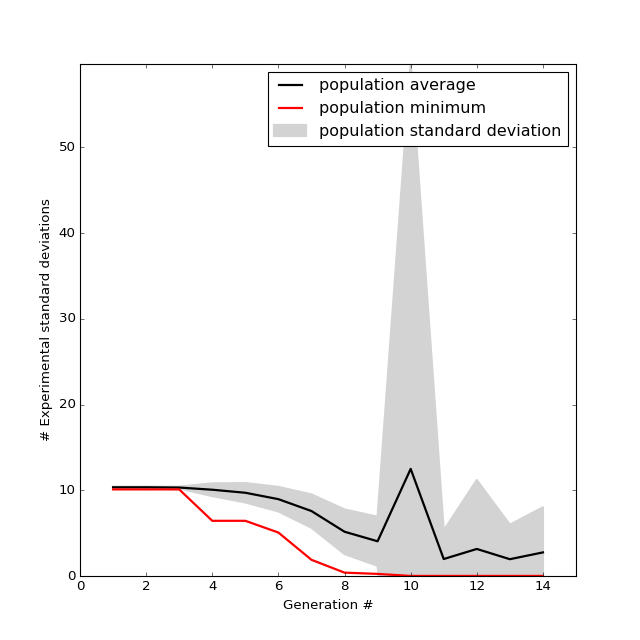

In [56]:
gen_numbers = logs.select('gen')
min_fitness = numpy.array(logs.select('min'))
max_fitness = logs.select('max')
mean_fitness = numpy.array(logs.select('avg'))
std_fitness = numpy.array(logs.select('std'))

fig, ax = plt.subplots(1, figsize=(8, 8), facecolor='white')
#fig_trip, ax_trip = plt.subplots(1, figsize=(10, 5), facecolor='white')

#plot_count = len(responses)
std = std_fitness
mean = mean_fitness
minimum = min_fitness
stdminus = mean - std                                                           
stdplus = mean + std

ax.plot(                                                                      
    gen_numbers,                                                                
    mean,                                                                       
    color='black',                                                              
    linewidth=2,                                                                
    label='population average')                                                 

ax.fill_between(                                                              
    gen_numbers,                                                                
    stdminus,                                                                   
    stdplus,                                                                    
    color='lightgray',                                                          
    linewidth=2,                                                                
    label=r'population standard deviation')                                     

ax.plot(                                                                      
    gen_numbers,                                                                
    minimum,                                                                    
    color='red',                                                                
    linewidth=2,                                                                
    label='population minimum')                                                 

ax.set_xlim(min(gen_numbers) - 1, max(gen_numbers) + 1)                       
ax.set_xlabel('Generation #')                                                 
ax.set_ylabel('# Experimental standard deviations')                                            
ax.set_ylim([0, max(stdplus)])                                                
ax.legend(loc="best") 

Let's plot the results of our optimisation.

<IPython.core.display.Javascript object>


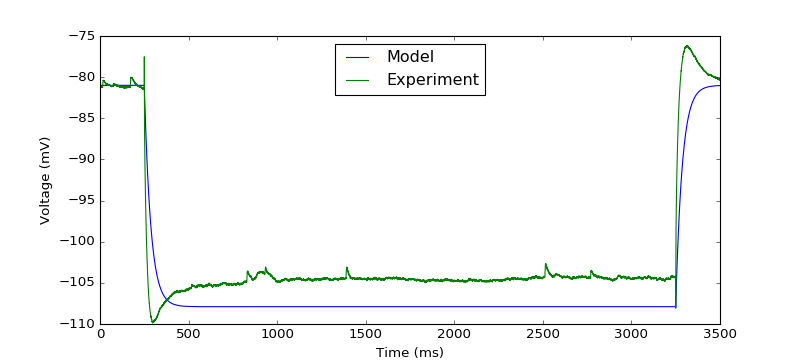

In [64]:
responses = twostep_protocol.run(cell_model=simple_cell, param_values=best_ind_dict, sim=nrn)
plot_responses(responses)